# Federated Learning for Image Classification

## Before we start

Before we start, please run the following to make sure that your environment is
correctly setup. If you don't see a greeting, please refer to the
[Installation](../install.md) guide for instructions. 

In [1]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

2024-07-22 10:09:56.899612: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-22 10:09:56.901376: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 10:09:56.924910: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 10:09:56.924951: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 10:09:56.924973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

b'Hello, World!'

## Preparing the input data


In [2]:
cifar100_train, cifar100_test = tff.simulation.datasets.cifar100.load_data()
# display(cifar100_train.client_ids)
# display(cifar100_test.element_type_structure)

Inspect the dataset, of simulated client nr 0

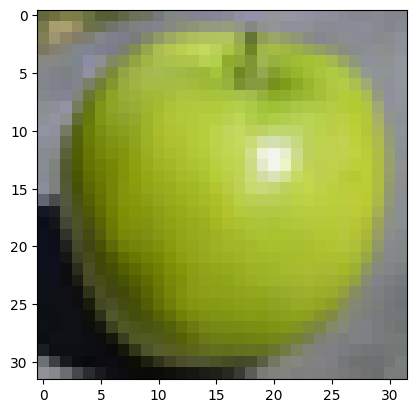

In [3]:
example_dataset = cifar100_train.create_tf_dataset_for_client(cifar100_train.client_ids[0])

example_element = next(iter(example_dataset))
plt.imshow(example_element['image'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

Now let's visualize the number of examples on each client for each MNIST digit label. In the federated environment, the number of examples on each client can vary quite a bit, depending on user behavior.

### Preprocessing the input data

Since the data is already a `tf.data.Dataset`,  preprocessing can be accomplished using Dataset transformations. Here, we flatten the `28x28` images
into `784`-element arrays, shuffle the individual examples, organize them into batches, and rename the features
from `pixels` and `label` to `x` and `y` for use with Keras. We also throw in a
`repeat` over the data set to run several epochs.

In [4]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 50
SHUFFLE_BUFFER = 250
PREFETCH_BUFFER = 25 # half of batch size

def preprocess(dataset):
    def batch_format_fn(element):
        """Adjust the function for CIFAR100's 32x32x3 images."""
        # Reshape and normalize CIFAR100 images
        return collections.OrderedDict(
            x=tf.reshape(element['image'], [-1, 32, 32, 3]),  # Normalize images to [0,1]
            y=tf.reshape(element['label'], [-1, 1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

# Here's a simple helper function that will construct a list of datasets from the given set of users as an input to a round of training or evaluation.
def make_federated_data(client_data, client_ids):\
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

Sample the set of clients once, andreuse the same set across rounds to speed up convergence (intentionally over-fitting to these few user's data).

In [5]:
sample_clients = cifar100_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(cifar100_train, sample_clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

preprocessed_example_dataset = preprocess(example_dataset)

Number of client datasets: 10
First dataset: <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>


## Creating a model with Keras

In [6]:
def create_keras_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(100, activation='softmax')
    ])

**Note:** we do not compile the model yet. The loss, metrics, and optimizers are introduced later.

In order to use any model with TFF, it needs to be wrapped in an instance of the
`tff.learning.models.VariableModel` interface, which exposes methods to stamp the model's
forward pass, metadata properties, etc., similarly to Keras, but also introduces
additional elements, such as ways to control the process of computing federated
metrics. Let's not worry about this for now; if you have a Keras model like the
one we've just defined above, you can have TFF wrap it for you by invoking
`tff.learning.models.from_keras_model`, passing the model and a sample data batch as
arguments, as shown below.

In [7]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## Training the model on federated data

Now that we have a model wrapped as `tff.learning.models.VariableModel` for use with TFF, we
can let TFF construct a Federated Averaging algorithm by invoking the helper
function `tff.learning.algorithms.build_weighted_fed_avg`, as follows.

Keep in mind that the argument needs to be a constructor (such as `model_fn`
above), not an already-constructed instance, so that the construction of your
model can happen in a context controlled by TFF (if you're curious about the
reasons for this, we encourage you to read the follow-up tutorial on
[custom algorithms](custom_federated_algorithms_1.ipynb)).

One critical note on the Federated Averaging algorithm below, there are **2**
optimizers: a _client_optimizer_ and a _server_optimizer_. The
_client_optimizer_ is only used to compute local model updates on each client.
The _server_optimizer_ applies the averaged update to the global model at the
server. In particular, this means that the choice of optimizer and learning rate
used may need to be different than the ones you have used to train the model on
a standard i.i.d. dataset. We recommend starting with regular SGD, possibly with
a smaller learning rate than usual. The learning rate we use has not been
carefully tuned, feel free to experiment.

In [8]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.0005),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.005))

Let's invoke the `initialize` computation to construct the server state.

In [9]:
train_state = training_process.initialize()

2024-07-22 10:10:04.302936: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:10:04.303039: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-22 10:10:04.331965: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:10:04.332215: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


The second of the pair of federated computations, `next`, represents a single
round of Federated Averaging, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

Conceptually, you can think of `next` as having a functional type signature that
looks as follows.

```
SERVER_STATE, FEDERATED_DATA -> SERVER_STATE, TRAINING_METRICS
```

In particular, one should think about `next()` not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server (`SERVER_STATE`), but each participating device contributes its own local dataset.

Let's run a single round of training and visualize the results. We can use the
federated data we've already generated above for a sample of users.

In [10]:
result = training_process.next(train_state, federated_train_data)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))
result = training_process.next(train_state, federated_train_data)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

2024-07-22 10:10:04.655693: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:10:04.655881: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-22 10:10:04.784852: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:10:04.784936: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-22 10:10:04.789455: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:10:04.789574: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-22 10:10:04.795700: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:10:04.795787: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.031), ('loss', 15.344856), ('num_examples', 5000), ('num_batches', 100)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.0324), ('loss', 15.4170685), ('num_examples', 5000), ('num_batches', 100)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


Let's run a few more rounds. As noted earlier, typically at this point you would
pick a subset of your simulation data from a new randomly selected sample of
users for each round in order to simulate a realistic deployment in which users
continuously come and go, but in this interactive notebook, for the sake of
demonstration we'll just reuse the same users, so that the system converges
quickly.

In [11]:
NUM_ROUNDS = 100
for round_num in range(2, NUM_ROUNDS):
  result = training_process.next(train_state, federated_train_data)
  train_state = result.state
  train_metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, train_metrics))

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.0322), ('loss', 15.441472), ('num_examples', 5000), ('num_batches', 100)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.0386), ('loss', 15.290486), ('num_examples', 5000), ('num_batches', 100)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.0398), ('loss', 15.166097), ('num_examples', 5000), ('num_batches', 100)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', Or

Training loss is decreasing after each round of federated training, indicating
the model is converging. There are some important caveats with these training
metrics, however, see the section on *Evaluation* later in this tutorial.

To see these metrics within TensorBoard, refer to the steps listed above in "Displaying model metrics in TensorBoard".

## Evaluation

All of our experiments so far presented only federated training metrics - the
average metrics over all batches of data trained across all clients in the
round. This introduces the normal concerns about overfitting, especially since
we used the same set of clients on each round for simplicity, but there is an
additional notion of overfitting in training metrics specific to the Federated
Averaging algorithm. This is easiest to see if we imagine each client had a
single batch of data, and we train on that batch for many iterations (epochs).
In this case, the local model will quickly exactly fit to that one batch, and so
the local accuracy metric we average will approach 1.0. Thus, these training
metrics can be taken as a sign that training is progressing, but not much more.

To perform evaluation on federated data, you can construct another *federated
computation* designed for just this purpose, using the
`tff.learning.build_federated_evaluation` function, and passing in your model
constructor as an argument. Note that unlike with Federated Averaging, where
we've used `MnistTrainableModel`, it suffices to pass the `MnistModel`.
Evaluation doesn't perform gradient descent, and there's no need to construct
optimizers.

For experimentation and research, when a centralized test dataset is available,
[Federated Learning for Text Generation](federated_learning_for_text_generation.ipynb)
demonstrates another evaluation option: taking the trained weights from
federated learning, applying them to a standard Keras model, and then simply
calling `tf.keras.models.Model.evaluate()` on a centralized dataset.

In [18]:

evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)
evaluation_state = evaluation_process.initialize()
model_weights = training_process.get_model_weights(train_state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
evaluation_output = evaluation_process.next(evaluation_state, federated_train_data)

federated_test_data = make_federated_data(cifar100_test, cifar100_test.client_ids[0:NUM_CLIENTS])

for round_num in range(1, NUM_ROUNDS + 1):
    evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)
    
    # Extract metrics from the evaluation output
    metrics = evaluation_output.metrics
    print('round {:2d}, metrics={}'.format(round_num, metrics))

2024-07-22 10:21:01.282661: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:21:01.282787: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-22 10:21:01.300751: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:21:01.300827: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-22 10:21:01.501860: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:21:01.501988: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-07-22 10:21:01.561492: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-07-22 10:21:01.561686: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('sparse_categorical_accuracy', 0.0), ('loss', 9.898775), ('num_examples', 500), ('num_batches', 10)])), ('total_rounds_metrics', OrderedDict([('sparse_categorical_accuracy', 0.0), ('loss', 9.898775), ('num_examples', 500), ('num_batches', 10)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('sparse_categorical_accuracy', 0.0), ('loss', 9.898775), ('num_examples', 500), ('num_batches', 10)])), ('total_rounds_metrics', OrderedDict([('sparse_categorical_accuracy', 0.0), ('loss', 9.898775), ('num_examples', 500), ('num_batches', 10)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
round  3, metrics=Ordere

In [52]:
def prepare_dataset(element):
    # Adjust the dataset to match the model's input requirements
    # Assuming 'image' key contains the input images and 'label' key contains the labels
    return collections.OrderedDict(
        conv2d_9_input=tf.reshape(element['image'], [-1, 32, 32, 3]),  # Reshape and assign to the expected input key
        y=tf.reshape(element['label'], [-1, 1])  # Reshape labels if necessary
    )

In [53]:
keras_model = create_keras_model()
keras_model.compile(
loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model_weights = training_process.get_model_weights(train_state)
model_weights.assign_weights_to(keras_model)
adjusted_dataset = cifar100_test.create_tf_dataset_from_all_clients().map(prepare_dataset)
adjusted_dataset = adjusted_dataset.map(lambda x: (x['conv2d_9_input'], x['y']))

loss, accuracy = keras_model.evaluate(adjusted_dataset, steps=10000, verbose=0)
print('\tEval: loss={l:.3f}, accuracy={a:.3f}'.format(l=loss, a=accuracy))

	Eval: loss=8.413, accuracy=0.063
